# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1. Rappel du besoin](#section_1_1)
    * [1.2. Expression du besoin](#section_1_2)
    * [1.3. Contraintes](#section_1_3)
* [2. Réalisation du modèle de classification](#chapter2)
    * [2.1. Import des librairies Python](#section_2_1) 
* [3. Analyse des résultats](#chapiter3)
* [4. Amélioration du modèle](#chapiter4)
* [5. Conclusion](#chapitre5)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

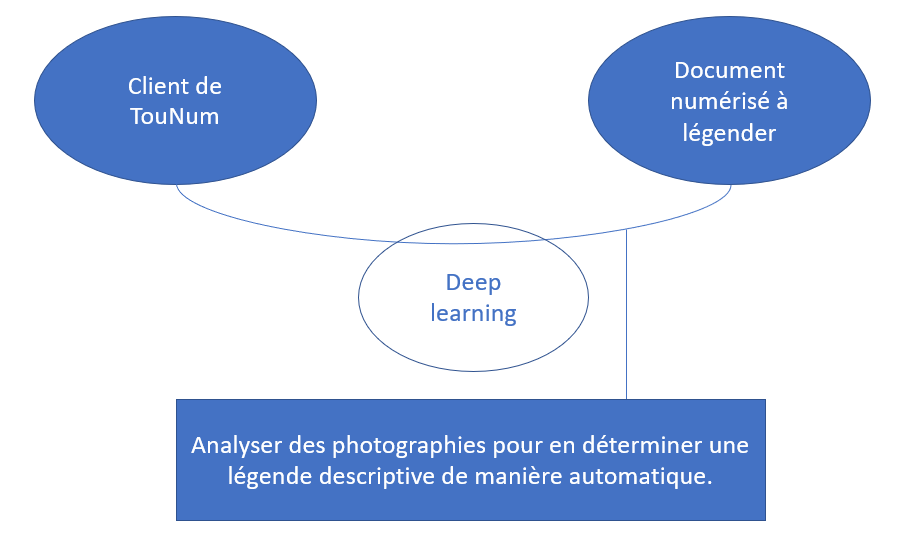
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Réalisation du modèle de classification <a class="anchor" id="chapter2"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [2]:
import pathlib

data_dir = pathlib.Path("Class")

In [3]:
image_h = 180
image_w = 180
batch_s = 32

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


In [5]:
class_names = train_set.class_names
print(class_names)

['Autre', 'Photo']


In [6]:
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 1)


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# #Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(image_h, 
#                                                               image_w,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )

# plt.figure(figsize=(10, 10))
# for images, _ in train_set.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Epoch 1/6
1036/1036 [==============================] - 133s 63ms/step - loss: 0.3368 - accuracy: 0.8283 - val_loss: 0.2852 - val_accuracy: 0.8685
Epoch 2/6
1036/1036 [==============================] - 64s 62ms/step - loss: 0.2500 - accuracy: 0.8897 - val_loss: 0.2243 - val_accuracy: 0.9019
Epoch 3/6
1036/1036 [==============================] - 72s 70ms/step - loss: 0.2114 - accuracy: 0.9098 - val_loss: 0.2122 - val_accuracy: 0.9106
Epoch 4/6
1036/1036 [==============================] - 66s 64ms/step - loss: 0.1914 - accuracy: 0.9198 - val_loss: 0.1899 - val_accuracy: 0.9191
Epoch 5/6
1036/1036 [==============================] - 63s 61ms/step - loss: 0.1756 - accuracy: 0.9280 - val_loss: 0.1753 - val_accuracy: 0.9313
Epoch 6/6
1036/1036 [==============================] - 59s 57ms/step - loss: 0.1555 - accuracy: 0.9365 - val_loss: 0.1994 - val_accuracy: 0.9244


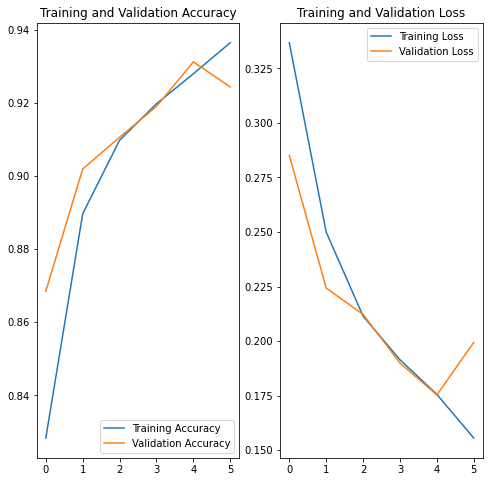

In [9]:
# Le modèle
complete_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
# Compilation du modèle
complete_model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
# complete_model.summary()

# Enrainement du modèle
epochs = 6
with tf.device('/device:GPU:0'):
    history = complete_model.fit(
        train_set,
        validation_data=test_set,
        epochs=epochs,
      )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

C:\Users\jbcst\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 6/16


C:\Users\jbcst\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1036/1036 [==============================] - 72s 69ms/step - loss: 0.1197 - accuracy: 0.9528 - val_loss: 0.1587 - val_accuracy: 0.9403
Epoch 7/16
1036/1036 [==============================] - 81s 78ms/step - loss: 0.1090 - accuracy: 0.9580 - val_loss: 0.1577 - val_accuracy: 0.9414
Epoch 8/16
1036/1036 [==============================] - 77s 75ms/step - loss: 0.1050 - accuracy: 0.9594 - val_loss: 0.1578 - val_accuracy: 0.9420
Epoch 9/16
1036/1036 [==============================] - 78s 76ms/step - loss: 0.1038 - accuracy: 0.9602 - val_loss: 0.1576 - val_accuracy: 0.9425
Epoch 10/16
1036/1036 [==============================] - 68s 65ms/step - loss: 0.1026 - accuracy: 0.9605 - val_loss: 0.1578 - val_accuracy: 0.9424
Epoch 11/16
1036/1036 [==============================] - 73s 70ms/step - loss: 0.1002 - accuracy: 0.9613 - val_loss: 0.1583 - val_accuracy: 0.9425
Epoch 12/16
1036/1036 [==============================] - 68s 65ms/step - loss: 0.0999 - accuracy: 0.9616 - val_loss: 0.1584 - val_acc

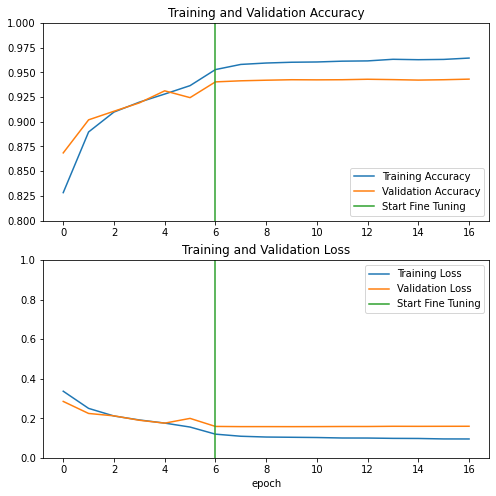

In [10]:
complete_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])
#model.summary()
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
with tf.device('/device:GPU:0'):
    history_fine = complete_model.fit(train_set,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=test_set)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs,epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs,epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Accuracy, ROC Curve, and AUC

Let's evaluate the accuracy of our model:

In [11]:
from sklearn.metrics import classification_report

predictions = complete_model.predict(test_set)
predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
true_categories = tf.concat([y for x, y in test_set], axis=0)


print(classification_report(true_categories, predicted_categories, target_names = class_names ))

              precision    recall  f1-score   support

       Autre       0.96      0.96      0.96      6340
       Photo       0.88      0.87      0.88      1941

    accuracy                           0.94      8281
   macro avg       0.92      0.92      0.92      8281
weighted avg       0.94      0.94      0.94      8281



In [12]:
complete_model.evaluate(test_set)

259/259 [==============================] - 2s 8ms/step - loss: 0.1595 - accuracy: 0.9431


[0.15951162576675415, 0.9431228041648865]

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

predictions = complete_model.predict(test_set)

conf_matrix = confusion_matrix(true_categories, predicted_categories)
precision_score = precision_score(true_categories, predicted_categories)
recall_score = recall_score(true_categories, predicted_categories)
f1_score = f1_score(true_categories, predicted_categories)


TP = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
calc_precision_accuracy = TP/(TP+FP)
calc_recall_accuracy = TP/(TP+FN)


print(conf_matrix)
print("Precision score: "+str(precision_score)+" Recall Score: "+str(recall_score)+" F1 Score: "+str(f1_score))
print("Calculated precision score: "+str(calc_precision_accuracy)+" Calculated recall score: "+ str(calc_recall_accuracy))


[[6115  225]
 [ 246 1695]]
Precision score: 0.8828125 Recall Score: 0.8732612055641422 F1 Score: 0.878010878010878
Calculated precision score: 0.8828125 Calculated recall score: 0.8732612055641422


Now, let's calculate our ROC curve and plot it.

First, let's make predictions on our validation set. When using generators to make predictions, we must first turn off shuffle (as we did when we created validation_generator) and reset the generator:

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


In [14]:
complete_model.save('saved_model/my_model')


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [15]:
from tensorflow.keras.models import load_model

complete_model = load_model('saved_model/my_model')

In [16]:
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.preprocessing import image

onlyfiles = [f for f in listdir('images_test') if isfile(join('images_test', f))]

fig = plt.figure(figsize=(25, 25))
ax = []

for i in range(len(onlyfiles)):

  img = image.load_img('images_test/'+onlyfiles[i], target_size=(180, 180))
  x = image.img_to_array(img)
  # plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)

  plt.axis('off')
  
  #rendre ligne colonne dynamique par rapport au nb images dans le fichier
  ax.append( fig.add_subplot(math.ceil(len(onlyfiles)/4), 4, i+1) )

  images = np.vstack([x])
  classes = complete_model.predict(images, batch_size=10)

  if classes[0]<0.5:
    ax[-1].set_title(onlyfiles[i] + " n'est pas une photo")  # set title
  else:
    ax[-1].set_title(onlyfiles[i] + " est une photo")  # set title
  plt.imshow(img)


plt.show()


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'images_test'

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np

# from keras.preprocessing import image

# # predicting images
# image_path = '20210928_161035.jpg'
# img = image.load_img(image_path, target_size=(180, 180))
# x = image.img_to_array(img)
# plt.imshow(x/255.)
# x = np.expand_dims(x, axis=0)

# images = np.vstack([x])
# classes = complete_model.predict(images, batch_size=10)
# print(classes[0])
# if classes[0]<0.5:
#   print(image_path + " n'est pas une photo")
# else:
#   print(image_path + " est une photo")
 